In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load and prepare data
titanic = sns.load_dataset('titanic')
df = titanic[['pclass', 'sex', 'age', 'survived']].copy()

# Handle missing values in 'age' by grouping by 'pclass' and 'sex' and filling with the mean
df['age'] = df.groupby(['pclass', 'sex'])['age'].transform(lambda x: x.fillna(x.mean()))

# Convert sex to binary
df['sex'] = df['sex'].map({'female': 0, 'male': 1})

# Split data
X = df[['pclass', 'sex', 'age']]
y = df['survived']

# 70% training, 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Normalize age using Z-score
train_age_mean = X_train['age'].mean()
train_age_std = X_train['age'].std()
X_train['age'] = (X_train['age'] - train_age_mean) / train_age_std
X_test['age'] = (X_test['age'] - train_age_mean) / train_age_std

# Build model
model = Sequential([              # Input layer: 3 units (pclass, age, sex)
    Dense(10, activation = 'relu', input_shape = (3,)), # Hidden layer: 10 units
    Dense(1, activation = 'sigmoid') # Output layer: 1 unit (survived)
])

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy', # Binary classification problem
              metrics = ['accuracy']) # Track accuracy as the evaluation metric

# Train model
history = model.fit(X_train, y_train,
                    epochs = 100, # Train for 100 full passes through the dataset
                    batch_size = 32, # 32 samples per gradient update
                    validation_split = 0.2, # 20% of training data for validation
                    verbose = 0) # Suppress training output

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose = 0)
print(f'Test accuracy: {test_acc:.2f}')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test accuracy: 0.80


In [5]:
# Confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred > 0.5)
cm_df = pd.DataFrame(cm, index = ['Actual Negative', 'Actual Positive'], columns = ['Predicted Negative', 'Predicted Positive'])
print('Confusion Matrix:')
print(cm_df)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                 134                  23
Actual Positive                  30                  81


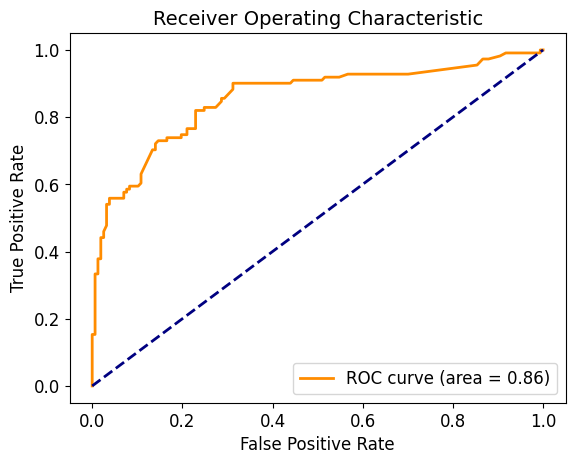

In [9]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.xlabel('False Positive Rate', size = 12)
plt.ylabel('True Positive Rate', size = 12)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.title('Receiver Operating Characteristic', size = 14)
plt.legend(loc = "lower right", fontsize = 12)
plt.show()

The higher and to the left the ROC curve is, the better the model is. Since it is over the diagonal, our model has a good performance.
The dashed blue diagonal represents a model which classifies randomly.